<a href="https://colab.research.google.com/github/marcexpositg/CRISPRed/blob/master/01.DescriptiveAnalysis/1.2.gRNALibDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.2. gRNA library distribution

## 1. Introduction

Before analyzing the genomic data to see if the target regions have been edited, it is important to analyze the quality of the gRNA library transfected to the cells. The two objectives of the quality control are:
- Determine if all gRNAs were present in the transfected library, to check if all targeted genomic regions could have been edited.
- Observe the relative abundance of each gRNA in the library to check if all targeted genomic regions have the same probability of being edited.

**Experimental background:**

All data used in this project was obtained in a single experiment with four different conditions. In all conditions, C2C12 cells were transfected with two different plasmids. One of the plasmids is the one carrying the gene for a gene editing enzyme, while the other contains the gRNA library.

We used three types of gene editing enzymes:

- CRISPR-Cas9: introduces a double stranded break in the genome
- ABE: is an adenine base editor, which replaces an adenine for a guanine
- CBE: is a cytosine base editor, which replaces a cytosine for a timine

We also used two different libraries:

- gRNA perfect library: contains 1785 different gRNAs targeting different sites in the genome.
- gRNA mismatch library: is identical to the perfect library but one of the nucleotides in the gRNA is not complementary to the sequence in the genome.

Hence, the four conditions of the experiment were transfected with the following pairs of plasmids, including the nomenclature of the sample that will be used here:

- **Cas9P:** Cas9+Perf -> expect to observe in/dels and microhomology repair
- **Cas9P:** Cas9+Mism -> since the mismatch library is not exactly the sequence in the genome, the efficiency must be lower than with the perfect library
- **ABE:** ABE+Perf -> expect to observe A->G changes
- **CBE:** CBE+Perf -> expect to observe C->T changes

48h after transfection, the DNA was extracted from the cells of each condition. This DNA sample was sequenced using two methods for each condition, one sequencing the genome an another the gRNA library plasmids:

- Targeted sequencing of the gRNAs: the region containing the gRNA in the gRNA library **plasmid** was amplified and sequenced, to observe the plasmids that got into the cells.
- Enriched **genomic** samples: the target regions of the genomic DNA were selected, purified, and sequenced using shutgun.

## 2. Count reads for each gRNA

To determine the relative abundancy of each gRNA, the number of reads of each gRNA in the targeted sequencing files was calculated.

Targeted sequencing was done using illumina and adjusting the read length to 250. Illumina creates two `fastq` files, one of them containing reads in one sense (R1) and the other in the inverse sense (R2). First, that reads were paired based on their ID. In this case, since the amplified regions to sequence were shorter (182 nt) than the sequencing read length (250 nt), both R1 and R2 contain the same information but in reverse-complementary.

Below, the first eight lines of this `fastq` files are shown below. Each read takes up 4 lines in the `fastq` file, the first is the read ID (unique for every read), the second is the nucleotide sequence, the third is the strand, and the fourth is the quality of each nucleotide. You can see that the read ID is the same but for a 1 or 2 indicating if the file belongs to R1 or to R2. The sequence in one file is exactly the same as in the other but in reverse complement.

```
$ head -n 8 6-Cas9-pef-pls_R*_qfilt.fastq
==> 6-Cas9-pef-pls_R1_qfilt.fastq <==
@M00724:143:000000000-CW3RB:1:1101:14937:1001 1:N:0:6
CTTGTGGAAAGGACGAAACACCGTGTTTGGCAAAATAACCACACGCATTGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTTAGACCCAGCTTTCTTGTACAAAGTTGGCATTAAAGGGCGAATTCCAGC
+
8BCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGFGGGGGGGFAFGGGFGGGGGGG
@M00724:143:000000000-CW3RB:1:1101:11039:1001 1:N:0:6
CTTGTGGAAAGGACGAAACCCCGTGTTTGCTGAGCTTCAGGTTCCTCCGGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTTTTAGACCCAGCTTTCTTGTACAAAGTTGGCATTAAAGGGCGAATTCCAGC
+
8BCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

==> 6-Cas9-pef-pls_R2_qfilt.fastq <==
@M00724:143:000000000-CW3RB:1:1101:14937:1001 2:N:0:6
GCTGGAATTCGCCCTTTAATGCCAACTTTGTACAAGAAAGCTGGGTCTAAAAAAAAGCACCGACTCGGTGCCACTTTTTCAAGTTGATAACGGACTAGCCTTATTTTAACTTGCTATTTCTAGCTCTAAAACAATGCGTGTGGTTATTTTGCCAAACACGGTGTTTCGTCCTTTCCACAAGA
+
CCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGFGGGGGGGGGGGGGGFGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
@M00724:143:000000000-CW3RB:1:1101:11039:1001 2:N:0:6
GCTGGAATTCGCCCTTTAATGCCAACTTTGTACAAGAAAGCTGGGTCTAAAAAAAAGCACCGACTCGGTGCCACTTTTTCAAGTTGATAACGGACTAGCCTTATTTTAACTTGCTATTTCTAGCTCTAAAACCGGAGGAACCTGAAGCTCAGCAAACACGGGGTTTCGTCCTTTCCACAAGA
+
CCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGFGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
```



Hence, both R1 and R2 contain the information so we only need to examine one of the two files for each sample (we select the R1). Therefore, there is one file to analyze per sample:

- `6-Cas9-pef-pls_R1_qfilt.fastq`
- `7-Cas9-miss-pls_R1_qfilt.fastq`
- `8-ABE-pls_R1_qfilt.fastq`
- `9-CBE-pls_R1_qfilt.fastq`

Since this files are relatively large, we will only exemplify how the script to count gRNAs works in one of the files, using the file :`6-Cas9-pef-pls_R1_qfilt.fastq`.

A previous version of the notebook required mounting google drive.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls drive/Shared drives
#%cd "drive/Shared\ drives/CRISPred/01.DescriptiveAnalysis"
#%cd "/content/drive/My Drive/CRISPred/01.DescriptiveAnalysis"
#!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access 'drive/Shared': No such file or directory
ls: cannot access 'drives': No such file or directory
/content/drive/My Drive/CRISPred/01.DescriptiveAnalysis
 0.ColabBasics.ipynb		        1.4.CoverageAnalysis   gRNALib_analysis
'1.1. SequencingDataProcessing.ipynb'   C3HCoordinates	       gRNALib_seqs
 1.2.gRNALibDistribution.ipynb	        CRISPR-GANotebook
 1.3.CoordiantesToC3H.ipynb	        GenomicCoverage


For the analysis, we need the gRNA library sequences. This information is kept in the `gRNALib_perf` file for the perfect gRNA library and in `gRNALib_perf` for the mismatch gRNA library. Below, we show the first 2 gRNAs for each of this files. Comparing the gRNA sequences between the mismatch and the perfect it is clear that mismatch conitain a single mutation in a nucleotide, in the case of the first gRNA the mutation is highlighted as: GCA**A**GAAGGAGAAAGACGCGGGG.

In [ ]:
!head -n 4 gRNALib_seqs/gRNALib_*.fasta

==> gRNALib_seqs/gRNALib_mism.fasta <==
>ENSMUSG00000078919_gR57r
GCAAGAAGGAGAAAGACGCGGGG
>ENSMUSG00000078919_gR97r
ATCTCTCAACAGATAGACACCGG

==> gRNALib_seqs/gRNALib_perf.fasta <==
>ENSMUSG00000078919_gR57r
GCAGGAAGGAGAAAGACGCGGGG
>ENSMUSG00000078919_gR97r
ATCTGTCAACAGATAGACACCGG


The script that counts the number of times a gRNA appears is very simple:

1. Import the gRNA library as a dictionary pairing the gRNA sequence with a field for the number of counts (initialized as 0), omitting the name of each gRNA using the fact that they are preceeded by ">".

2. Look for each gRNA as it is and in reverse complement in each of the reads of the sequencing data, and count the number of time it appears.

3. Export the data as a `csv` file.

Note that the script removes the PAM sequence (the last 3 nucleotides in the gRNA) because this are found on the target site of the genome, but not in the gRNA, so we would not observe it in the reads. It also checks the gRNA sequence as it is and in reverse complement, so that we don't need to analyze the reverse complement reads (R2) file.

The script could be easily improved so that reads in which one gRNA has been found are no longer analyzed, or to only analyze the lines containing read sequence (not all the 4 lines for each read).

This script was originally executed in a cluster passing three arguments indicating the location of the files, but here it has been adapted to run an example to look for the perfect library in the Cas9+ perfect library sample.

Also, a progress bar has been added because when executing the script with the complete sequencing file (.`fastq`) takes a few minutes. A reduced version of the file has been created (_Reduced) which is 1/20 of the original size, and is analyzed by default instead of the complete file.

In [ ]:
!pip install biopython   # The script requires biopython to create the reverse complement

     |████████████████████████████████| 2.3MB 8.2MB/s 


In [ ]:
#!/usr/bin/env/ python
import sys
from Bio.Seq import Seq

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def get_gRNA_lib(gRNA_file):
    f = open(gRNA_file)
    gRNA_lib = {}
    for line in f:
        if line[0] != ">":
            # remove NGG PAM sequence(present in genome but not in plasmid gRNA)
            gRNA_seq = line.rstrip()[0:-3]
            
            if gRNA_seq in gRNA_lib:
                raise AssertionError("gRNA library file contains duplicate entries!")
            else:
                gRNA_lib[gRNA_seq] = 0
    f.close()
    return gRNA_lib


def count_gRNA(gRNA_lib, seq_file):
    f = open(seq_file)

    gRNA_count = gRNA_lib.copy()
    l = len(gRNA_lib)
    i = 0
    printProgressBar(0,l, prefix = 'Progress:', suffix = 'Complete', length = 50)

    for gRNA in gRNA_count:
        
        printProgressBar(i + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        i += 1

        gRNA_revcomp = str(Seq(gRNA).reverse_complement())
        f.seek(0)  # go to the begginng of the file
        for line in f:
            # R1 and R2 reads are always overlapping, hence we only need to look at
            # the R1 file and search for both the oriented and the reverse complement.
            if gRNA in line or gRNA_revcomp in line:
                gRNA_count[gRNA] += 1 
            
    f.close
    return gRNA_count

## Originally, filenames are obtained from command line call of the script
## could be improved with getopt
#try:
#    plasmid_seq_data = sys.argv[1]
#    gRNA_lib_file = sys.argv[2]
#    csv_out_file = sys.argv[3]
#except IndexError:
#    raise SystemExit(f"Usage: gRNA_dist_count.py <plasmid_seq_file> <gRNA_library_file> <output_file_name.csv>")

# Here, we specify the example location
# to execute complete analysis (it takes a relatively long time)
#plasmid_seq_data = "gRNALib_analysis/6-Cas9-pef-pls_R1_qfilt.fastq"
# execute a smaller analyisis
plasmid_seq_data = "gRNALib_analysis/6-Cas9-pef-pls_R1_qfilt_Reduced.fastq"
gRNA_lib_file = "gRNALib_seqs/gRNALib_perf.fasta"
csv_out_file = "gRNALib_analysis/Cas9P_p_example.csv"

# Create dictionary from gRNAs
gRNA_lib = get_gRNA_lib(gRNA_lib_file)
# Count each gRNA
gRNA_counts = count_gRNA(gRNA_lib, plasmid_seq_data)

# Export to file
with open(csv_out_file, 'w') as f:
    for key in gRNA_counts.keys():
        f.write("%s,%s\n"%(key,gRNA_counts[key]))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


The resulting `csv` file contains the same information that the gRNA dictionary object had. The first ten lines are displayed below.

In [ ]:
!head gRNALib_analysis/Cas9P_p_example.csv

GCAGGAAGGAGAAAGACGCG,181
ATCTGTCAACAGATAGACAC,187
GCCGAGTTTGATTAGGAACC,134
AACAACACACAAATAAGCCC,120
ATTCTTGTTCCTAAGAGCTA,151
GGGAAAAGTGAAGGGGGGCG,176
TGGGGAAAAGTGAAGGGGGG,264
TTTCCCCACGATATGCATCC,176
TCCAGGAAACCAAGCCTCCC,127
ACCGAACAGCTGACACTGGG,183




The script was executed 8 times. Half of them to look for the perfect library in all four samples (Cas9P_p, Cas9M_p, ABE_p, CBE_p), and the other half to look for the mismatch library in all four samples (same names ended in _m).

## 3. Study the relative abundance of each gRNA

### Script

Now that the number of times a gRNA appears in the reads is known, the results can be plotted to see the distribution of the count number.

Note that the samples in which the perfect library was used were also analyzed to check if they contain any gRNAs from the mismatch library, and viceversa. This was done because the gRNA library was synthesized in a single tube and, even if amplified with different primers for cloning into a plasmid, it would be possible to get some perfect gRNAs in the mismatch library and viceversa.

Since we study two sets/groups of gRNAs (perfect and mismatch) in each of the four samples, a violin plot offers the perfect representation to visiualize all the data. A histogram with the distribution of the library that was added to each sample (perfect in Cas9P, ABE, and CBE; and mismatch in Cas9M) is also created.

               ABE          CBE        Cas9P        Cas9M
count  1785.000000  1785.000000  1785.000000  1785.000000
mean    142.810644   131.526611   150.660504     5.975910
std      36.528599    31.056138    34.097906     3.124649
min       0.000000     0.000000     0.000000     0.000000
25%     119.000000   111.000000   129.000000     4.000000
50%     139.000000   129.000000   148.000000     6.000000
75%     163.000000   149.000000   169.000000     8.000000
max     445.000000   363.000000   376.000000    22.000000
               ABE          CBE        Cas9P        Cas9M
count  1785.000000  1785.000000  1785.000000  1785.000000
mean      8.686275     7.826891     8.904762    84.917647
std       5.328992     4.188088     3.998865    18.362641
min       0.000000     0.000000     0.000000     1.000000
25%       5.000000     5.000000     6.000000    73.000000
50%       8.000000     7.000000     8.000000    84.000000
75%      12.000000    10.000000    11.000000    96.000000
max      35.00

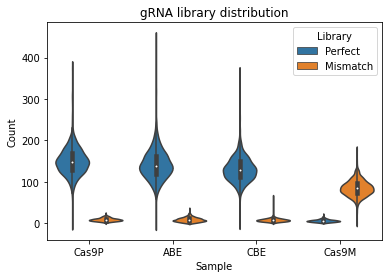

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## INPUT DATA
ABE = pd.read_csv('gRNALib_analysis/ABE_p.csv', squeeze=True, index_col=0, header=None)
CBE = pd.read_csv('gRNALib_analysis/CBE_p.csv', squeeze=True, index_col=0, header=None)
Cas9P = pd.read_csv('gRNALib_analysis/Cas9P_p.csv', squeeze=True, index_col=0, header=None)
Cas9M = pd.read_csv('gRNALib_analysis/Cas9M_p.csv', squeeze=True, index_col=0, header=None)
ABE_m = pd.read_csv('gRNALib_analysis/ABE_m.csv', squeeze=True, index_col=0, header=None)
CBE_m = pd.read_csv('gRNALib_analysis/CBE_m.csv', squeeze=True, index_col=0, header=None)
Cas9P_m = pd.read_csv('gRNALib_analysis/Cas9P_m.csv', squeeze=True, index_col=0, header=None)
Cas9M_m = pd.read_csv('gRNALib_analysis/Cas9M_m.csv', squeeze=True, index_col=0, header=None)

## ADAPT DATA TO A PANDAS OBJECT
perf = pd.DataFrame({'ABE': ABE, 'CBE': CBE,'Cas9P': Cas9P, 'Cas9M': Cas9M})
mism = pd.DataFrame({'ABE':ABE_m,'CBE':CBE_m,'Cas9P':Cas9P_m,'Cas9M':Cas9M_m})

## GET BASIC STATISTICS OF THE DATA
print(perf.describe())
print(mism.describe())


## CREATE A HISTOGRAM
for col_name in perf.columns:
    if col_name == 'Cas9M':
        sns.kdeplot(mism[col_name], shade=True)
    else:
        sns.kdeplot(perf[col_name], shade=True)
plt.legend(title='Sample')
plt.title('Density Plot for gRNA distribution')
plt.xlabel('Count')
plt.ylabel('Density')
#plt.show()
plt.savefig("gRNALib_analysis/Histogram.png", dpi=300)
plt.clf()


## CREATE A VIOLIN PLOT
perf["Library"] = "Perfect"
mism["Library"] = "Mismatch"
total = perf.append(mism)
totalmelt = total.melt(id_vars=["Library"],value_name="Count",var_name="Sample")

sns.violinplot(x="Sample",y="Count",hue="Library",data=totalmelt,
                          scale="count",order=["Cas9P","ABE","CBE","Cas9M"]) 
                          #use scale="area" to not normalize
plt.title('gRNA library distribution')
#plt.savefig("gRNALib_analysis/Violin_plot.png",dpi=300)
plt.savefig("/content/Violin_plot.png",dpi=600)
#plt.show()

### Results

The statistics printed with the execution of the code show that the mean of the counts of the gRNA library that was used in each sample (perfect for all samples except for Cas9M, which uses mismatch) is much higher than the mean of the other library, confirming that both libraries were correctly separated and the presence of some gRNAs of the other library is not important. A t-test could be done to confirm that the difference is significant, as the distribution of the counts follows a normal distribution.

Another important conclusion that can be obtained from the statistics is that the quartiles are very close, so most of the gRNA have a similar number of counts. The means are around 130 counts for each gRNA for the perfect libraries and at 84 counts for the mismatch library. However, we are more interested in knowing the distribution of the number of counts than the mean.

The same information can be obtained from the violin plot shown below. It is clear that the presence of the incorrect type of library is residual in comparision to the presence of the correct type of library in all samples, as the distributions do not overlap. It can also be observed that the count distribution of all samples that used the same library (perfect) is similar but different than the other library (mismatch). Interestingly, there are a few gRNAs that appear over 200 times.

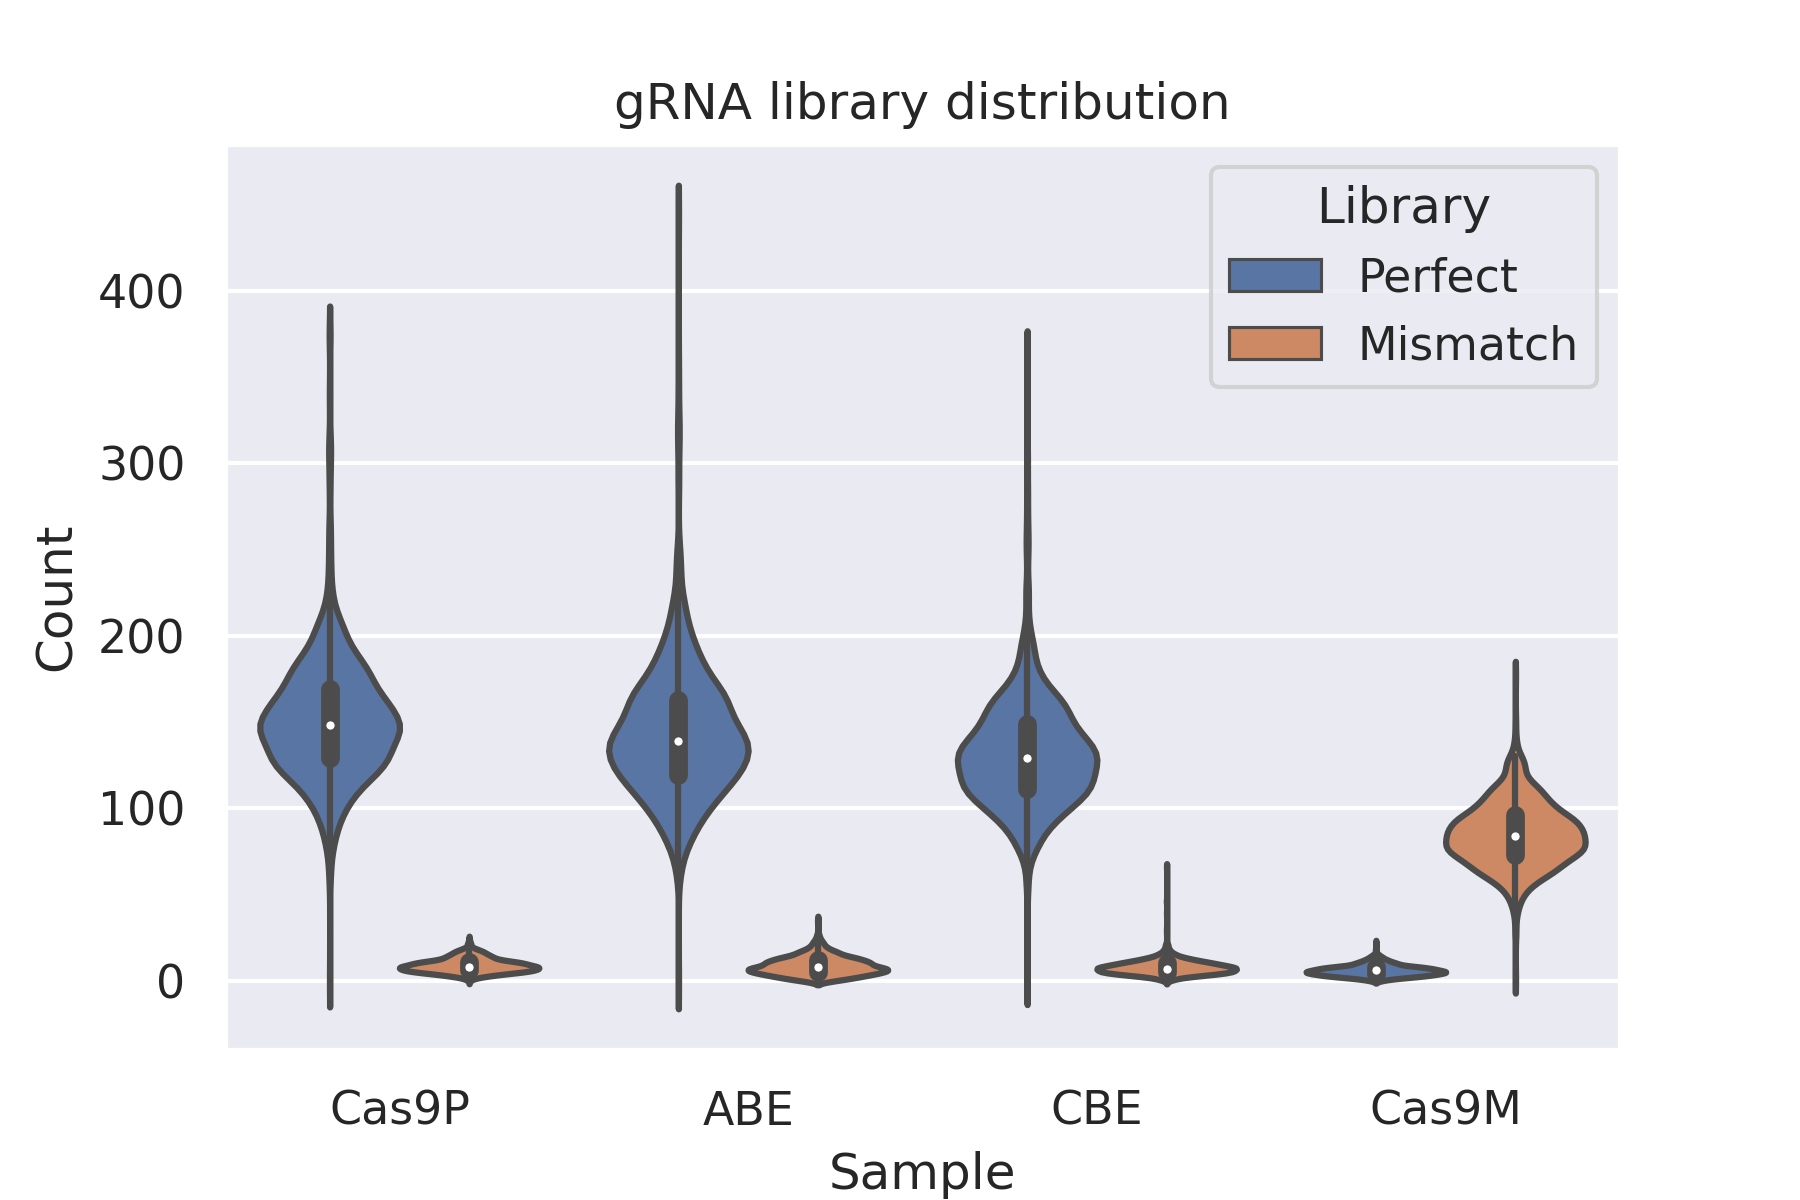

In [ ]:
from IPython.display import Image
Image('gRNALib_analysis/Violin_plot.png',height=500)

The histogram representation facilitates visualizing how the distribution of the libraries overlap between them. Note that the histogram only represents the counts of the type of library used for each sample. Interestingly, the perfect library obtained has the same size and distribution in all samples, while the mismatch library has a lower mean and less dispersion (which produces a higher peak). This indicates that the dispersion in counts comes from the original library in the plasmid, which was common in all samples except the Cas9M. Since the same distribution has been observed after transfecting and extracting the DNA, it can be concluded that all gRNAs get transfected according to their abundance, and that the transfection procedure does not bias the library in any sense.

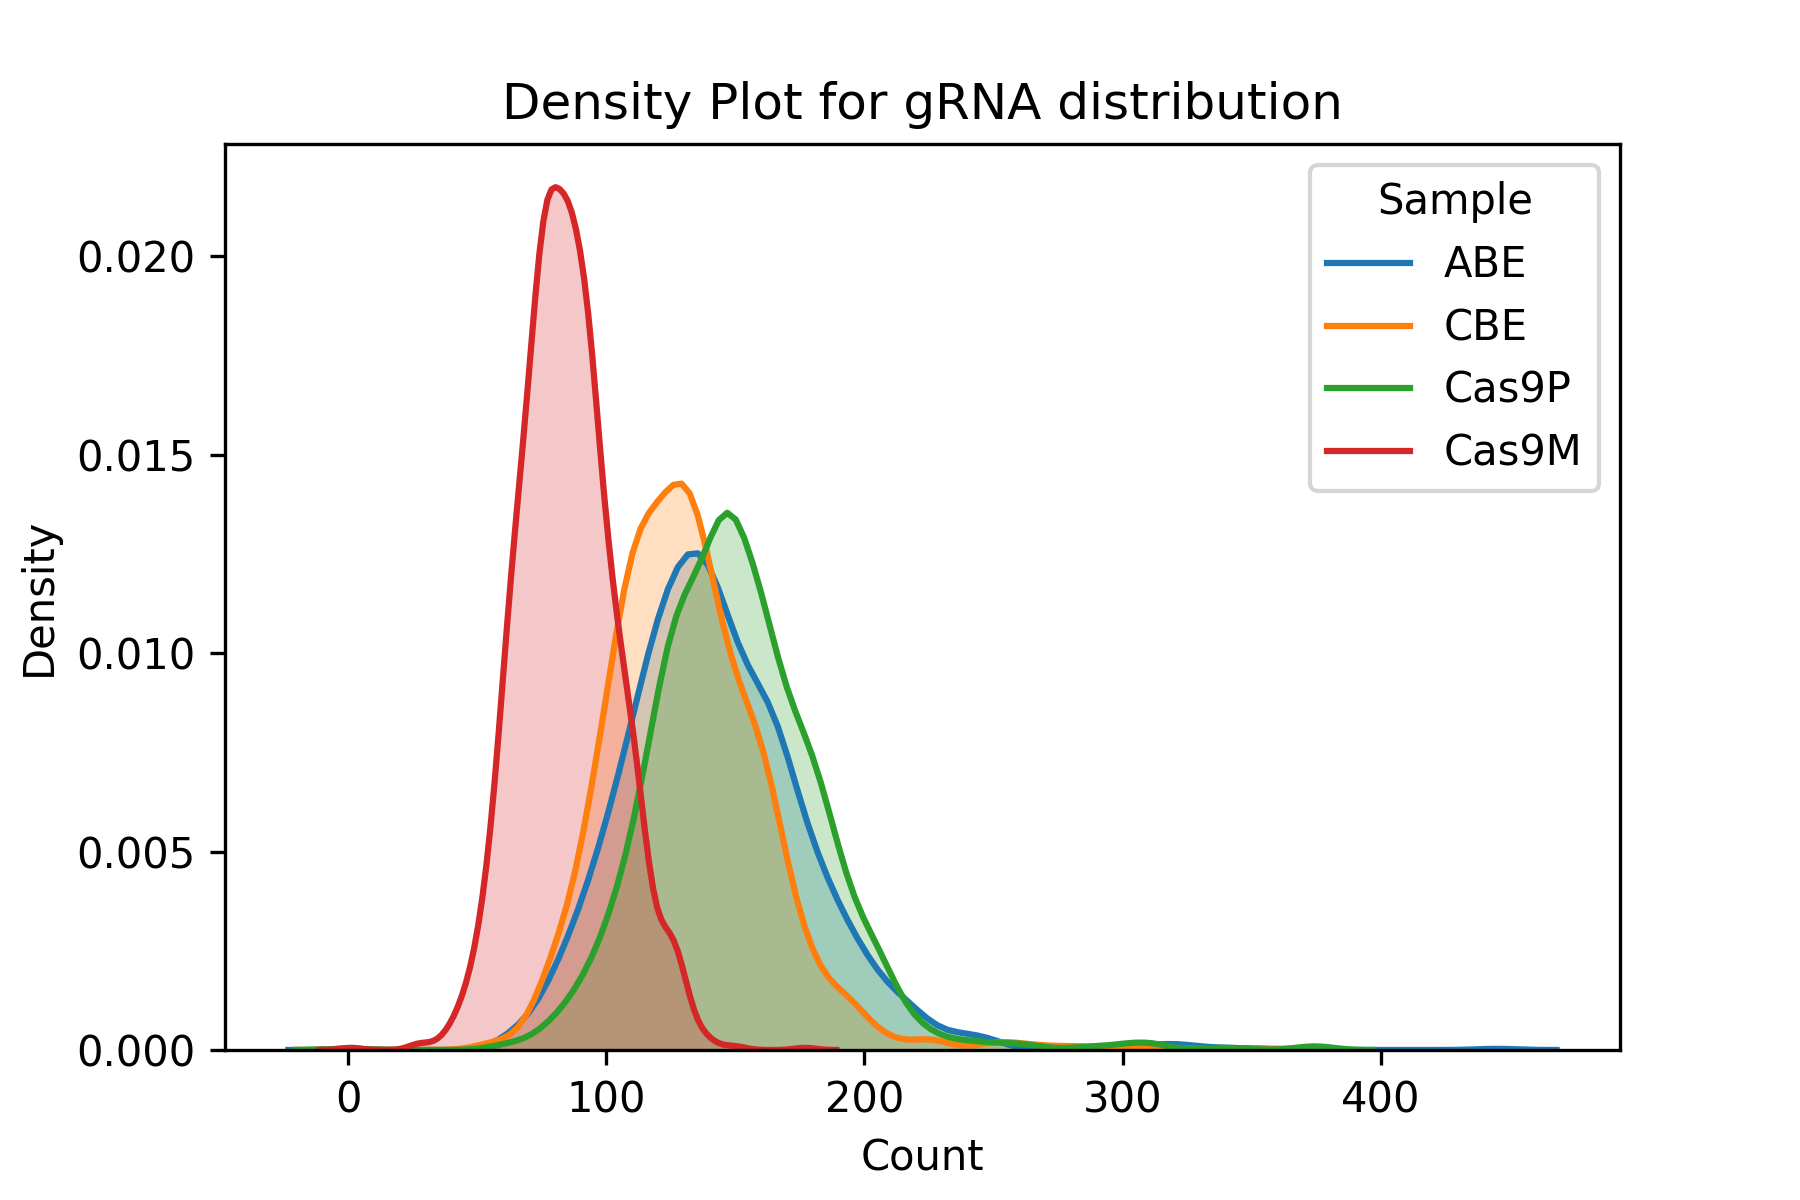

In [ ]:
from IPython.display import Image
Image('gRNALib_analysis/Histogram.png',height=500)

Finally, and since the minimum value of counts obtained has been zero, it is interesting to check the counts produced manually to identify how many gRNAs have been counted zero times.

For that, a `gRNACounts.xlsx` spreadsheet was created by merging all the csv files and sorted. A screenshot of that spreadsheet is shown below. It can be clearly seen that only one gRNA is absent in all samples. This is probably a manufacturing error, as this particular gRNA may have been synthesized with a mutation so that it has not been counted by the script. This indicates that all gRNAs were present in the sample, which is essential for the success of the experiment.

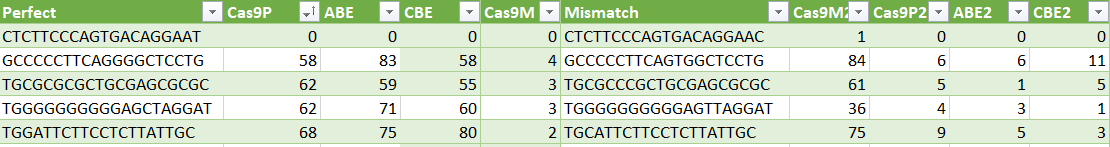

In [ ]:
from IPython.display import Image
Image('gRNALib_analysis/Spreadsheet counts.png')

## 4. Conclusions

- All gRNAs from the library were present in the samples except from one, which was absent in all samples (probably a DNA synthesis error).
- All gRNAs are present in a similar number of counts. Most of them are between 100 and 200 counts, indicating there is not even a order of magnitude of difference in their abundance. In experiments like that, three orders of magnitude are sometimes present between the abundances of members of a library, so the results obtained here are very promising.
- The abundance of the incorrect type of library (presence of mismatch gRNA in the samples where perfect gRNA library was used, and viceversa) is low, confirming a good separation between the libraries.

Overall, the results indicate that the gRNA library used in experiments was fully representative of the library as we expected it, without cross-contamination of the incorrect type of library, and that most of the gRNAs have a similar number of counts, which guarantees that the editing efficiency of each target genomic location is not excessively influenced by differences in the relative aboundance of gRNAs.

## 5. Possible future tasks

- Look for sequencing reads where no gRNA has been identified. Are they abundant? do they contain gRNAs but with mutations?

- Look for a gRNA similar to the one that has not been found in the sequencing reads. Is its absence due to a mutation in the synthesis process or it is just absent at all?

- The gRNA count distribution seems similar in all samples that used the same library. Confirm this by making a three distribution plots where every point is a gRNA and the X and Y axis are its number of counts in different samples (thus, comparing the abundance of the same kind of gRNA in different samples). It should be correlated linearly.